In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
#% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
import tensorflow.keras.preprocessing.sequence as tkps

# Then you can use pad_sequences like this:
sequences = tkps.pad_sequences


# Defining the functions which will enable us to read the text file

In [3]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [4]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("C:/Users/91790/Downloads/hin-eng/hin.txt")
hind_eng = to_lines(data)
hind_eng = array(hind_eng)

In [6]:
print(len(data))

430232


In [7]:
print(len(hind_eng))

2979


In [8]:
hind_eng

array([['Wow!', 'वाह!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)'],
       ['Duck!', 'झुको!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179041 (fastrizwaan)'],
       ['Duck!', 'बतख़!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179042 (fastrizwaan)'],
       ...,
       ['Democracy is the worst form of government, except all the others that have been tried.',
        'लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी सारी तरह की सरकारों को अंदेखा किया जाए तो।',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1550 (Zifre) & #480226 (minshirui)'],
       ['If my boy had not been killed in the traffic accident, he would be a college student now.',
        'अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया होता, तो वह अभी कॉलेज जा रहा होता।',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #399492 (blay_paul) & #515450 (minshirui)'],
       ["When I was a kid, touching bugs didn

# Taking 2979 sentence pairs for training

In [9]:
hind_eng = hind_eng[:2979,:]

In [10]:
hind_eng

array([['Wow!', 'वाह!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)'],
       ['Duck!', 'झुको!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179041 (fastrizwaan)'],
       ['Duck!', 'बतख़!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179042 (fastrizwaan)'],
       ...,
       ['Democracy is the worst form of government, except all the others that have been tried.',
        'लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी सारी तरह की सरकारों को अंदेखा किया जाए तो।',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1550 (Zifre) & #480226 (minshirui)'],
       ['If my boy had not been killed in the traffic accident, he would be a college student now.',
        'अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया होता, तो वह अभी कॉलेज जा रहा होता।',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #399492 (blay_paul) & #515450 (minshirui)'],
       ["When I was a kid, touching bugs didn

# We'll now get rid of all the punctuations in both the english and Hindi phrases by using maketrans

In [11]:
hind_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in hind_eng[:,0]]
hind_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in hind_eng[:,1]]

In [12]:
hind_eng

array([['Wow', 'वाह',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)'],
       ['Duck', 'झुको',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179041 (fastrizwaan)'],
       ['Duck', 'बतख़',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179042 (fastrizwaan)'],
       ...,
       ['Democracy is the worst form of government except all the others that have been tried',
        'लोकतंत्र सरकार का सबसे घिनौना रूप है अगर बाकी सारी तरह की सरकारों को अंदेखा किया जाए तो।',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1550 (Zifre) & #480226 (minshirui)'],
       ['If my boy had not been killed in the traffic accident he would be a college student now',
        'अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया होता तो वह अभी कॉलेज जा रहा होता।',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #399492 (blay_paul) & #515450 (minshirui)'],
       ['When I was a kid touching bugs didnt bother me a

# Converting the text to lower case

In [13]:
for i in range(len(hind_eng)):
    hind_eng[i,0] = hind_eng[i,0].lower()

    hind_eng[i,1] = hind_eng[i,1].lower()

In [14]:
eng_l = []
hind_l = []

# populate the language lists with sentence lengths
for i in hind_eng[:,0]:
    eng_l.append(len(i.split()))

for i in hind_eng[:,1]:
    hind_l.append(len(i.split()))

In [15]:
length_df = pd.DataFrame({'eng':eng_l, 'hind':hind_l})

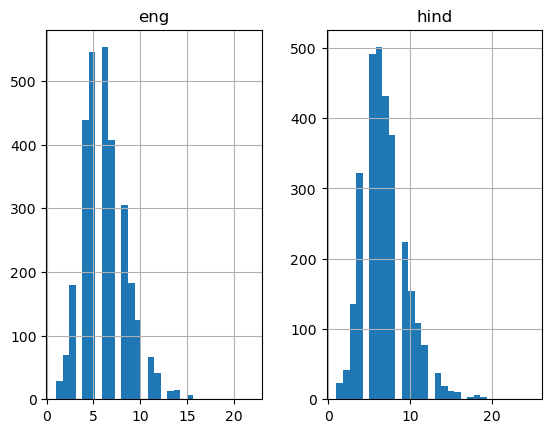

In [16]:
length_df.hist(bins = 30)
plt.show()

#The plot shows frequency of occurence v/s length of phrase for both languages

In [17]:
length_df['eng'].value_counts()

6     553
5     546
4     438
7     407
8     305
9     182
3     179
10    125
2      69
11     67
12     42
1      28
14     15
13     13
15      6
16      1
17      1
18      1
22      1
Name: eng, dtype: int64

We can see that the maximum length sequence in english is 22

In [18]:
length_df['hind'].value_counts()

6     501
5     491
7     431
8     376
4     322
9     224
10    154
3     136
11    109
12     77
2      42
13     37
1      23
14     19
15     12
16     11
18      6
17      3
19      3
21      1
25      1
Name: hind, dtype: int64

We can see that the maximum length sequence in Hindi is 25

In [19]:
#Tokenization is the process of converting each word in the vocabulary into an integer based on frequency of occurence

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

eng_tokenizer = tokenization(hind_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 22 # MAx Length of English
print('English Vocabulary Size: %d' % eng_vocab_size)

hind_tokenizer = tokenization(hind_eng[:, 1])
hind_vocab_size = len(hind_tokenizer.word_index) + 1

hind_length = 25  # Max Length of Hindi
print('French Vocabulary Size: %d' % hind_vocab_size)


English Vocabulary Size: 2404
French Vocabulary Size: 3061


In [20]:
# encode and pad sequences
#encoding means replacing each word with its corresponding number
#Padding essentially means adding zeros to make the length of every sequence equal
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [21]:
from keras.utils import pad_sequences

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(hind_eng, test_size=0.2, random_state = 12)

In [23]:
trainX = encode_sequences(hind_tokenizer, hind_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

testX = encode_sequences(hind_tokenizer, hind_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now we'll build the Sequential model.
The first layer is the embedding layer which projects each token in an N dimensional vector space
LSTM is the artificial recurrent neural net architecture.
It can not only proces past data but take feedback from future data as well.

In the second LSTM layer, we have set return sequences as True becuase we need outputs of all hidden units and not just the last one.

In [ ]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

model = build_model(hind_vocab_size, eng_vocab_size, hind_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 25, 512)           1567232   
                                                                 
 lstm_8 (LSTM)               (None, 512)               2099200   
                                                                 
 repeat_vector_4 (RepeatVect  (None, 22, 512)          0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 22, 512)           2099200   
                                                                 
 dense_4 (Dense)             (None, 22, 2404)          1233252   
                                                                 
Total params: 6,998,884
Trainable params: 6,998,884
Non-trainable params: 0
____________________________________________

In [ ]:
filename = 'model.h1.Eng_Hind'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=30, batch_size=512,
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 7.6983
Epoch 1: val_loss improved from inf to 6.20108, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 64s 15s/step - loss: 7.6983 - val_loss: 6.2011
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 3.5199
Epoch 2: val_loss improved from 6.20108 to 2.42796, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 22s 7s/step - loss: 3.5199 - val_loss: 2.4280
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 2.3854
Epoch 3: val_loss improved from 2.42796 to 2.33402, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 29s 8s/step - loss: 2.3854 - val_loss: 2.3340
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 2.3046
Epoch 4: val_loss improved from 2.33402 to 2.27752, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 38s 11s/step - loss: 2.3046 - val_loss: 2.2775
Epoch 5/30
4/4 [==============================] - ETA: 0s - loss: 2.2591
Epoch 5: val_loss improved from 2.27752 to 2.24772, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 36s 10s/step - loss: 2.2591 - val_loss: 2.2477
Epoch 6/30
4/4 [==============================] - ETA: 0s - loss: 2.2298
Epoch 6: val_loss improved from 2.24772 to 2.23737, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 40s 11s/step - loss: 2.2298 - val_loss: 2.2374
Epoch 7/30
4/4 [==============================] - ETA: 0s - loss: 2.2147
Epoch 7: val_loss improved from 2.23737 to 2.22573, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 35s 10s/step - loss: 2.2147 - val_loss: 2.2257
Epoch 8/30
4/4 [==============================] - ETA: 0s - loss: 2.1941
Epoch 8: val_loss did not improve from 2.22573
4/4 [==============================] - 26s 7s/step - loss: 2.1941 - val_loss: 2.2265
Epoch 9/30
4/4 [==============================] - ETA: 0s - loss: 2.1709
Epoch 9: val_loss improved from 2.22573 to 2.14480, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 36s 10s/step - loss: 2.1709 - val_loss: 2.1448
Epoch 10/30
4/4 [==============================] - ETA: 0s - loss: 2.1159
Epoch 10: val_loss did not improve from 2.14480
4/4 [==============================] - 26s 7s/step - loss: 2.1159 - val_loss: 2.2569
Epoch 11/30
4/4 [==============================] - ETA: 0s - loss: 2.1290
Epoch 11: val_loss did not improve from 2.14480
4/4 [==============================] - 26s 6s/step - loss: 2.1290 - val_loss: 2.1484
Epoch 12/30
4/4 [==============================] - ETA: 0s - loss: 2.1767
Epoch 12: val_loss improved from 2.14480 to 2.10064, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 35s 10s/step - loss: 2.1767 - val_loss: 2.1006
Epoch 13/30
4/4 [==============================] - ETA: 0s - loss: 2.0588
Epoch 13: val_loss improved from 2.10064 to 2.06247, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 40s 11s/step - loss: 2.0588 - val_loss: 2.0625
Epoch 14/30
4/4 [==============================] - ETA: 0s - loss: 2.1532
Epoch 14: val_loss did not improve from 2.06247
4/4 [==============================] - 29s 7s/step - loss: 2.1532 - val_loss: 2.0753
Epoch 15/30
4/4 [==============================] - ETA: 0s - loss: 2.0335
Epoch 15: val_loss improved from 2.06247 to 2.02149, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 37s 10s/step - loss: 2.0335 - val_loss: 2.0215
Epoch 16/30
4/4 [==============================] - ETA: 0s - loss: 2.0264
Epoch 16: val_loss did not improve from 2.02149
4/4 [==============================] - 24s 6s/step - loss: 2.0264 - val_loss: 2.2416
Epoch 17/30
4/4 [==============================] - ETA: 0s - loss: 2.0494
Epoch 17: val_loss improved from 2.02149 to 1.98543, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 33s 9s/step - loss: 2.0494 - val_loss: 1.9854
Epoch 18/30
4/4 [==============================] - ETA: 0s - loss: 2.0070
Epoch 18: val_loss did not improve from 1.98543
4/4 [==============================] - 23s 6s/step - loss: 2.0070 - val_loss: 1.9879
Epoch 19/30
4/4 [==============================] - ETA: 0s - loss: 1.9622
Epoch 19: val_loss did not improve from 1.98543
4/4 [==============================] - 24s 6s/step - loss: 1.9622 - val_loss: 2.0048
Epoch 20/30
4/4 [==============================] - ETA: 0s - loss: 2.0113
Epoch 20: val_loss improved from 1.98543 to 1.95970, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 35s 10s/step - loss: 2.0113 - val_loss: 1.9597
Epoch 21/30
4/4 [==============================] - ETA: 0s - loss: 1.9998
Epoch 21: val_loss did not improve from 1.95970
4/4 [==============================] - 22s 6s/step - loss: 1.9998 - val_loss: 1.9638
Epoch 22/30
4/4 [==============================] - ETA: 0s - loss: 1.9247
Epoch 22: val_loss did not improve from 1.95970
4/4 [==============================] - 24s 6s/step - loss: 1.9247 - val_loss: 1.9673
Epoch 23/30
4/4 [==============================] - ETA: 0s - loss: 1.9827
Epoch 23: val_loss improved from 1.95970 to 1.95697, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 34s 10s/step - loss: 1.9827 - val_loss: 1.9570
Epoch 24/30
4/4 [==============================] - ETA: 0s - loss: 1.9223
Epoch 24: val_loss did not improve from 1.95697
4/4 [==============================] - 24s 6s/step - loss: 1.9223 - val_loss: 2.0406
Epoch 25/30
4/4 [==============================] - ETA: 0s - loss: 1.9383
Epoch 25: val_loss did not improve from 1.95697
4/4 [==============================] - 28s 7s/step - loss: 1.9383 - val_loss: 2.0888
Epoch 26/30
4/4 [==============================] - ETA: 0s - loss: 1.9263
Epoch 26: val_loss improved from 1.95697 to 1.91522, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 35s 10s/step - loss: 1.9263 - val_loss: 1.9152
Epoch 27/30
4/4 [==============================] - ETA: 0s - loss: 1.9048
Epoch 27: val_loss did not improve from 1.91522
4/4 [==============================] - 27s 7s/step - loss: 1.9048 - val_loss: 2.0208
Epoch 28/30
4/4 [==============================] - ETA: 0s - loss: 1.9262
Epoch 28: val_loss did not improve from 1.91522
4/4 [==============================] - 27s 7s/step - loss: 1.9262 - val_loss: 1.9739
Epoch 29/30
4/4 [==============================] - ETA: 0s - loss: 1.8938
Epoch 29: val_loss improved from 1.91522 to 1.91234, saving model to model.h1.Eng_Hind


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


INFO:tensorflow:Assets written to: model.h1.Eng_Hind\assets


4/4 [==============================] - 38s 11s/step - loss: 1.8938 - val_loss: 1.9123
Epoch 30/30
4/4 [==============================] - ETA: 0s - loss: 1.8902
Epoch 30: val_loss did not improve from 1.91234
4/4 [==============================] - 27s 7s/step - loss: 1.8902 - val_loss: 2.0204


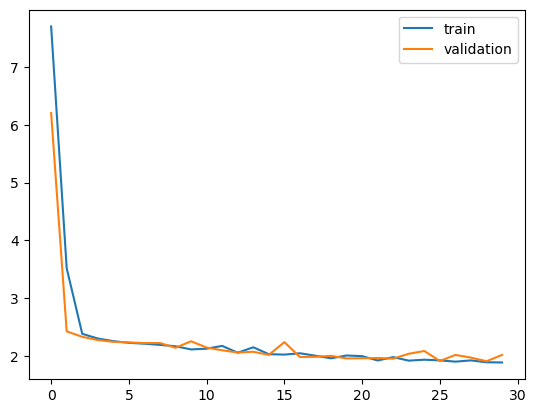

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h1')
preds = model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

19/19 [==============================] - 10s 326ms/step


In [ ]:
# Save the trained model
model.save('model.h1')

INFO:tensorflow:Assets written to: model.h1\assets


INFO:tensorflow:Assets written to: model.h1\assets


In [ ]:
import pickle

# Save the trained model in PKL format
with open('Trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\embedding
......vars
.........0
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\repeat_vector
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-09-02 11:00:46         3716
metadata.json                                  2023-09-02 11:00:46           64
variables.h5                                   2023-09-02 11:00:46     28020968


In [24]:
def get_word1(n, tokenizer):
    max_index = max(tokenizer.word_index.values())
    n = int(n[0] * max_index)  # Convert the floating-point number to an integer
    print(n)
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None


In [26]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word1(i[j], eng_tokenizer)
        if j > 0: #If it is not the first word
            if (t == get_word1(i[j-1], eng_tokenizer)) or (t == None):  #if the next word is same as the previous
                temp.append('')
            else:
                temp.append(t)

        else: #if it's not the first word
            if(t == None): #if we didn't get a valid code from dictionary
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
sumn = 0
for i in range(len(pred_df)):
    reference = pred_df['actual'][0]
    candidate = pred_df['predicted'][1]
    score = sentence_bleu([pred_df['actual'][i].split()],pred_df['predicted'][i].split())
    sumn+=score

print("The average BLEU score for the translation is {:.2f} %".format(sumn*100/len(pred_df)))

# Here we have calculated bleu score for every translation and taken an average

The average BLEU score for the translation is 67.00262030400634 %


After completing the training of my dataset for English to Hinglish translation,
I have achieved an average BLEU score of 67.00262030400634%.

The potential for further improvement in accuracy exists through the addition of more data points.
I have currently utilized 2979 data points, and with the incorporation of additional data, I can enhance the model's precision.